In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

In [2]:
df2 = pd.read_csv('combine_data.csv')

C:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10933460 entries, 0 to 10933459
Data columns (total 25 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   belongs_to_collection  int64  
 2   budget                 float64
 3   genres                 object 
 4   id                     int64  
 5   original_language      object 
 6   popularity             float64
 7   production_companies   object 
 8   production_countries   object 
 9   release_date           object 
 10  revenue                float64
 11  runtime                float64
 12  status                 object 
 13  title                  object 
 14  vote_average           float64
 15  vote_count             float64
 16  release_year           object 
 17  profit                 float64
 18  weighted_rating        float64
 19  cast                   object 
 20  director               object 
 21  keywords               object 
 22  userId          

In [4]:
df2 = df2.drop(['Unnamed: 0'], axis=1)

In [5]:
movies = df2[['id', 'userId', 'rating', 'title']].drop_duplicates(keep='first')
movies

,id,userId,rating,title
0,862,1923,3.0,Toy Story
1,862,2103,5.0,Toy Story
2,862,5380,1.0,Toy Story
3,862,6177,4.0,Toy Story
4,862,6525,4.0,Toy Story
...,...,...,...,...
10933455,111109,33940,2.5,Century of Birthing
10933456,111109,172224,3.0,Century of Birthing
10933457,111109,210792,3.0,Century of Birthing
10933458,111109,225396,3.5,Century of Birthing


<AxesSubplot:>

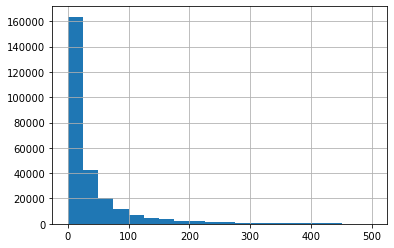

In [6]:
ratings_per_user = movies.groupby('userId')['rating'].count()
ratings_per_user.hist(bins=20, range=(0,500))

<AxesSubplot:>

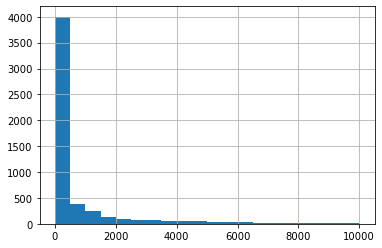

In [7]:
ratings_per_movies = movies.groupby('id')['rating'].count()
ratings_per_movies.hist(bins=20, range=(0,10000))

In [8]:
ratings_per_movies_df = pd.DataFrame(ratings_per_movies)
#Remove all movies which have less than 2000 ratings
cleaned_ratings_per_movies_df = ratings_per_movies_df[ratings_per_movies_df.rating >= 1000]
popular_movies = cleaned_ratings_per_movies_df.index.tolist()

In [9]:
ratings_per_user_df = pd.DataFrame(ratings_per_user)
#Remove all users which have voted less than 50 ratings
cleaned_ratings_per_movies_df = ratings_per_movies_df[ratings_per_movies_df.rating >= 20]
moviesholic_users = cleaned_ratings_per_movies_df.index.tolist()

In [10]:
filtered_ratings = movies[movies.userId.isin(moviesholic_users)]
filtered_ratings = filtered_ratings[filtered_ratings.id.isin(popular_movies)]
filtered_ratings

,id,userId,rating,title
497,949,174,4.0,Heat
498,949,346,4.0,Heat
502,949,523,4.0,Heat
504,949,609,5.0,Heat
505,949,624,4.0,Heat
...,...,...,...,...
10928583,3104,91571,4.0,Frankenstein Created Woman
10928595,3104,92393,2.0,Frankenstein Created Woman
10928982,3104,110130,5.0,Frankenstein Created Woman
10928996,3104,110603,5.0,Frankenstein Created Woman


In [11]:
refined_dataset = filtered_ratings.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()
#refined_dataset.shape

,userId,title,rating
0,2,A Nightmare on Elm Street,4.0
1,2,Almost Famous,1.0
2,2,Beauty and the Beast,4.0
3,2,Donnie Darko,3.0
4,2,Four Rooms,3.0


In [12]:
# pivot and create movie-user matrix
df = refined_dataset.pivot(
     index='title',
   columns='userId',
      values='rating').fillna(0)

df.head()

userId,2,3,5,6,11,12,13,14,15,16,...,162864,163937,166643,167858,168712,169842,169864,170399,172535,174371
title,,,,,,,,,,,,,,,,,,,,,
10 Items or Less,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2 Days in Paris,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"20,000 Leagues Under the Sea",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=3)

In [14]:
indices

array([[   0, 1152, 1250],
       [   1,  345,  146],
       [   2,  526,  556],
       ...,
       [1307,  996,   82],
       [1308,  143,  387],
       [1309,  343, 1084]], dtype=int64)

In [15]:
distances

array([[0.00000000e+00, 7.04419709e-01, 7.21487376e-01],
       [1.11022302e-16, 7.73452777e-01, 7.83108916e-01],
       [0.00000000e+00, 3.04592492e-01, 3.21687389e-01],
       ...,
       [0.00000000e+00, 6.18200587e-01, 6.56968804e-01],
       [1.11022302e-16, 5.56998571e-01, 6.10053329e-01],
       [0.00000000e+00, 6.65902655e-01, 6.96123276e-01]])

In [16]:
# get the index for 'movie_0'
index_for_movie = df.index.tolist().index('Sleepless in Seattle')
# find the indices for the similar movies
sim_movies = indices[index_for_movie].tolist()
# distances between 'movie_0' and the similar movies
movie_distances = distances[index_for_movie].tolist()
# the position of 'movie_0' in the list sim_movies
id_movie = sim_movies.index(index_for_movie)
# remove 'movie_0' from the list sim_movies
sim_movies.remove(index_for_movie)
# remove 'movie_0' from the list movie_distances
movie_distances.pop(id_movie)
print('The Nearest Movies to movie_0:', sim_movies)
print('The Distance from movie_0:', movie_distances)

The Nearest Movies to movie_0: [1157, 934]
The Distance from movie_0: [0.44893640801656776, 0.4741260325719945]


In [17]:
# copy df
df1 = df.copy()
number_neighbors = 10
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df.values)
distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)
user_index = df.columns.tolist().index(2)

for m,t in list(enumerate(df.index)):
  
 if df.iloc[m, user_index] == 0:
    sim_movies = indices[m].tolist()
    movie_distances = distances[m].tolist()
    
    if m in sim_movies:
      id_movie = sim_movies.index(m)
      sim_movies.remove(m)
      movie_distances.pop(id_movie) 

    
    else:
      sim_movies = sim_movies[:n_neighbors-1]
      movie_distances = movie_distances[:n_neighbors-1]
           
    movie_similarity = [1-x for x in movie_distances]
    movie_similarity_copy = movie_similarity.copy()
    nominator = 0

    for s in range(0, len(movie_similarity)):
      
      if df.iloc[sim_movies[s], user_index] == 0:

        if len(movie_similarity_copy) == (number_neighbors - 1):
          movie_similarity_copy.pop(s)
          
        else:
          movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))

      else:
        nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]

    if len(movie_similarity_copy) > 0:
      
      if sum(movie_similarity_copy) > 0:
        predicted_r = nominator/sum(movie_similarity_copy)

      else:
        predicted_r = 0

    else:
      predicted_r = 0
    df1.iloc[m,user_index] = predicted_r

In [18]:
def recommend_movies(user, num_recommended_movies):

  print('The list of the Movies user {} Has Watched \n'.format(user))

  for m in df[df[user] > 0][user].index.tolist():
    print(m)
  
  print('\n')

  recommended_movies = []

  for m in df[df[user] == 0].index.tolist():

    index_df = df.index.tolist().index(m)
    predicted_rating = df1.iloc[index_df, df1.columns.tolist().index(user)]
    recommended_movies.append((m, predicted_rating))

  sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)
  
  print('The list of the Recommended Movies \n')
  rank = 1
  for recommended_movie in sorted_rm[:num_recommended_movies]:
    print('{}: {} - predicted rating:{}'.format(rank, recommended_movie[0], recommended_movie[1]))
    rank = rank + 1


In [19]:
from pprint import pprint
print("Enter user id")
user= int(input())
print("Enter number of movies to be recommended:")
num_recommended_movies = int(input())

recommend_movies(user,num_recommended_movies)

Enter user id
2
Enter number of movies to be recommended:
10
The list of the Movies user 2 Has Watched 

A Nightmare on Elm Street
Almost Famous
Beauty and the Beast
Donnie Darko
Four Rooms
Hero
Interview with the Vampire
Jarhead
Monty Python and the Holy Grail
Mrs. Doubtfire
Night on Earth
Parenthood
Pirates of the Caribbean: Dead Man's Chest
Talk to Her
The 39 Steps
The Matrix Revolutions
The Passion of Joan of Arc


The list of the Recommended Movies 

1: Man of Iron - predicted rating:5.000000000000001
2: Muriel's Wedding - predicted rating:5.000000000000001
3: A Clockwork Orange - predicted rating:5.0
4: Cat on a Hot Tin Roof - predicted rating:5.0
5: Contempt - predicted rating:5.0
6: Dead Poets Society - predicted rating:5.0
7: Lucky Number Slevin - predicted rating:5.0
8: Man of Marble - predicted rating:5.0
9: My Own Private Idaho - predicted rating:5.0
10: Summer Storm - predicted rating:5.0


In [20]:
def movie_recommender(user, num_neighbors, num_recommendation):
  
  number_neighbors = num_neighbors

  knn = NearestNeighbors(metric='cosine', algorithm='brute')
  knn.fit(df.values)
  distances, indices = knn.kneighbors(df.values, n_neighbors=number_neighbors)

  user_index = df.columns.tolist().index(user)

  for m,t in list(enumerate(df.index)):
    if df.iloc[m, user_index] == 0:
      sim_movies = indices[m].tolist()
      movie_distances = distances[m].tolist()
    
      if m in sim_movies:
        id_movie = sim_movies.index(m)
        sim_movies.remove(m)
        movie_distances.pop(id_movie) 

      else:
        sim_movies = sim_movies[:num_neighbors-1]
        movie_distances = movie_distances[:num_neighbors-1]
           
      movie_similarity = [1-x for x in movie_distances]
      movie_similarity_copy = movie_similarity.copy()
      nominator = 0

      for s in range(0, len(movie_similarity)):
        if df.iloc[sim_movies[s], user_index] == 0:
          if len(movie_similarity_copy) == (number_neighbors - 1):
            movie_similarity_copy.pop(s)
          
          else:
            movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))
            
        else:
          nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]
          
      if len(movie_similarity_copy) > 0:
        if sum(movie_similarity_copy) > 0:
          predicted_r = nominator/sum(movie_similarity_copy)
        
        else:
          predicted_r = 0

      else:
        predicted_r = 0
        
      df1.iloc[m,user_index] = predicted_r
  recommend_movies(user,num_recommendation)

In [60]:
print("Enter user id")
user= int(input())
print("Enter number of movies to be recommended:")
num_recommendation = int(input())
movie_recommender(user,10,num_recommendation)

Enter user id
2
Enter number of movies to be recommended:
10
The list of the Movies user 2 Has Watched 

A Nightmare on Elm Street
Almost Famous
Beauty and the Beast
Donnie Darko
Four Rooms
Hero
Interview with the Vampire
Jarhead
Monty Python and the Holy Grail
Mrs. Doubtfire
Night on Earth
Parenthood
Pirates of the Caribbean: Dead Man's Chest
Talk to Her
The 39 Steps
The Matrix Revolutions
The Passion of Joan of Arc


The list of the Recommended Movies 

1: Man of Iron - predicted rating:5.000000000000001
2: Muriel's Wedding - predicted rating:5.000000000000001
3: A Clockwork Orange - predicted rating:5.0
4: Cat on a Hot Tin Roof - predicted rating:5.0
5: Contempt - predicted rating:5.0
6: Dead Poets Society - predicted rating:5.0
7: Lucky Number Slevin - predicted rating:5.0
8: Man of Marble - predicted rating:5.0
9: My Own Private Idaho - predicted rating:5.0
10: Summer Storm - predicted rating:5.0


In [36]:
conda install -c conda-forge scikit-surprise

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ADMIN\anaconda3

  added / updated specs:
    - scikit-surprise


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.11.0               |   py39hcbf5309_0        16.8 MB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    scikit-surprise-1.1.1      |   py39h5d4886f_2         538 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        17.4 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.9-2_cp39
  scikit-surprise    conda-forge/win-64::scikit-surprise-1.1.1-py39h5d4886f_2

The following packages will be UPDATED:

  conda              pkgs/main::conda-4.10.3-py39haa95532_0 --> conda-forge::conda-4.11.0-py39hcbf530



==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [38]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import SVD
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict


In [52]:
reader = Reader(line_format='user item rating', sep='\t')

reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(refined_dataset[['userId', 'title', 'rating']], reader)


In [53]:
data = Dataset.load_from_df(refined_dataset[['userId', 'title', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(n_epochs = 1, n_factors = 10),]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

In [54]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.942048,0.125987,0.274668


In [55]:
param_grid = {'n_factors': [10], 'n_epochs': [35], 'lr_all': [0.001],
              'reg_all': [0.08]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

0.8854543965340671
{'n_factors': 10, 'n_epochs': 35, 'lr_all': 0.001, 'reg_all': 0.08}


In [57]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8747


0.8746621109217854